<br><br>

# Heart Disease Prediction using k-Nearest Neighbors

This notebook demonstrates a machine learning approach to predicting heart disease using the k-Nearest Neighbors (k-NN) algorithm. We'll work with a comprehensive dataset containing patient information including demographics, clinical measurements, and diagnostic results.

## Overview

Heart disease remains one of the leading causes of death worldwide, making early detection and risk assessment crucial for patient care. This analysis explores how machine learning can assist in identifying patients at risk for heart disease based on readily available clinical data.

## What We'll Cover

1. **Exploratory Data Analysis (EDA)** - Understanding our dataset structure, distributions, and relationships
2. **Data Cleaning** - Handling inconsistencies and preparing data for modeling  
3. **Feature Selection** - Identifying the most predictive variables using correlation analysis
4. **Model Building** - Developing k-NN classifiers with single and multiple features
5. **Hyperparameter Optimization** - Fine-tuning model parameters using grid search
6. **Model Evaluation** - Assessing performance on unseen test data

The dataset contains 12 features including patient age, sex, chest pain type, blood pressure, cholesterol levels, and various cardiac measurements, with the goal of predicting heart disease diagnosis.

In [62]:
# import libraries
import pandas as pd
import numpy as np 
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# import seaborn as sns
# import matplotlib.pyplot as plt
# %matplotlib inline

## EDA: Descriptive Statistics

The data population are patients who have been observed and the following information collected about them:


1. `Age`: age of the patient [years]
2. `Sex`: sex of the patient [M: Male, F: Female]
3. `ChestPainType`: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. `RestingBP`: resting blood pressure [mm Hg]
5. `Cholesterol`: serum cholesterol [mm/dl]
6. `FastingBS`: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. `RestingECG`: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]
9. `ExerciseAngina`: exercise-induced angina [Y: Yes, N: No]
10. `Oldpeak`: oldpeak = ST [Numeric value measured in depression]
11. `ST_Slope`: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. `HeartDisease`: output class [1: heart disease, 0: Normal]
<br><br>

## Inital Review of the Data
<br><Br>

In [73]:
#load dataset
hd = pd.read_csv("heart-disease.csv")

In [64]:
hd.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

<br><br>
As expected the dataset seems to contain numerical and categorical features. Here is a better view of the data types. <br><br>

In [ ]:

dtypes = hd.dtypes
dtypes_tble = tabulate(dtypes.reset_index().values, headers=['Column', 'Data Type'], tablefmt='pipe')
print(dtypes_tble)
dtypes_val_tbl = tabulate(dtypes.value_counts().reset_index().values, headers=['Data Type', 'Count'], tablefmt='pipe')
print(dtypes_val_tbl)

<br><br>

### Data Types of Each Column

| Column         | Data Type   |
|:---------------|:------------|
| Age            | int64       |
| Sex            | object      |
| ChestPainType  | object      |
| RestingBP      | int64       |
| Cholesterol    | int64       |
| FastingBS      | int64       |
| RestingECG     | object      |
| MaxHR          | int64       |
| ExerciseAngina | object      |
| Oldpeak        | float64     |
| ST_Slope       | object      |
| HeartDisease   | int64       |

<br><bt>

### Count of Each Data Type

| Data Type   |   Count |
|:------------|--------:|
| int64       |       6 |
| object      |       5 |
| float64     |       1 |


`7` features in total are numerical while `5` are categorical. However, two of the numerical features, `FastingBS` and `HeartDisease` are categorical as well. 

We will focus on the numerical variables first.

In [ ]:

# Select only numerical columns
# Select only numerical columns
numerical_cols = hd.select_dtypes(include=[np.number]).columns.tolist()

# Calculate central tendencies
results = []
for col in numerical_cols:
    mean_val = hd[col].mean()
    median_val = hd[col].median()
    mode_val = hd[col].mode()[0] if not hd[col].mode().empty else None
    min_val = hd[col].min()
    max_val = hd[col].max()
    
    results.append([col, mean_val, median_val, mode_val, min_val, max_val])

# Create table
headers = ['Column', 'Mean', 'Median', 'Mode', 'Min', 'Max']
print(tabulate(results, headers=headers, tablefmt='pipe', floatfmt='.2f'))

<br><br>

## Heart Disease Central Tendencies
The table below summarizes the central tendencies of the numerical features in the dataset:


| Column       |   Mean |   Median |   Mode |   Min |    Max |
|:-------------|-------:|---------:|-------:|------:|-------:|
| Age          |  53.51 |    54.00 |  54.00 | 28.00 |  77.00 |
| RestingBP    | 132.40 |   130.00 | 120.00 |  0.00 | 200.00 |
| Cholesterol  | 198.80 |   223.00 |   0.00 |  0.00 | 603.00 |
| FastingBS    |   0.23 |     0.00 |   0.00 |  0.00 |   1.00 |
| MaxHR        | 136.81 |   138.00 | 150.00 | 60.00 | 202.00 |
| Oldpeak      |   0.89 |     0.60 |   0.00 | -2.60 |   6.20 |
| HeartDisease |   0.55 |     1.00 |   1.00 |  0.00 |   1.00 |

<br><br>

From the table above, we can observe that:

- The average age of patients is ~`53` years.
- The median for `Cholesterol` is higher than its mean by roughly `25` mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.
- `RestingBP` and `Cholesterol` have a minimum value of zero.
- There don't seem to be any missing values in these columns. But we will have to confirm it across the entire dataset as well.

`RestingBP` can't be `0`. And, as per the [American Heart Association](https://www.heart.org/en/health-topics/cholesterol/about-cholesterol/what-your-cholesterol-levels-mean), serum cholesterol is a composite of different measurements. So, it is unlikely that `Cholesterol` would be `0` as well. We will have to clean both of these up later.

Next, we will look at the categorical variables. It would also be beneficial to look at how the target feature, `HeartDisease`, is related to those categories. Before that, let's quickly check if there are any missing values in the dataset or not.

In [ ]:

from tabulate import tabulate


tbl = hd.isna().sum()
print(tabulate(tbl.reset_index().values, headers=['Column', 'Missing Values'], tablefmt='pipe'))


<br><br>
***Columns With Missing Values***<br>

| Column         |   Missing Values |
|:---------------|-----------------:|
| Age            |                0 |
| Sex            |                0 |
| ChestPainType  |                0 |
| RestingBP      |                0 |
| Cholesterol    |                0 |
| FastingBS      |                0 |
| RestingECG     |                0 |
| MaxHR          |                0 |
| ExerciseAngina |                0 |
| Oldpeak        |                0 |
| ST_Slope       |                0 |
| HeartDisease   |                0 |

There are no missing values in this dataset!

In [ ]:


tbl = hd.describe(include=['object'])
print(tabulate(tbl.reset_index().values, headers=['Column', 'Count', 'Unique', 'Top', 'Freq'], tablefmt='pipe'))

<br><br>

## EDA: Categorical Data

We identified that most of the categorical columns are all of dtype **object**.
<br><br>

|        | Column   | Count   | Unique   | Top   | Freq   |
|:-------|:---------|:--------|:---------|:------|:-------|
| count  | 918      | 918     | 918      | 918   | 918    |
| unique | 2        | 4       | 3        | 2     | 3      |
| top    | M        | ASY     | Normal   | N     | Flat   |
| freq   | 725      | 496     | 552      | 547   | 460    |

<br><br>

We can confirm that those columns are indeed categorical given the number of unique values in each of them. But, we can't gather much else. Also, `FastingBS` and `HeartDisease` are categorical as well since they only contain binary values. We can confirm that quickly as well.
<br><br>

Let's start looking at the categories in more detail.



In [ ]:

import pandas as pd
from bokeh.plotting import figure, show, curdoc, output_notebook, output_file
from bokeh.palettes import Bright6
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.layouts import row, column

cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

hdv = pd.read_csv("heart-disease.csv", usecols=cols)

genders = ["Male", "Female"]
sex_counts_vals = hdv["Sex"].value_counts()
sex_counts = (int(sex_counts_vals["M"]), int(sex_counts_vals["F"]))
sex_count_strs = [str(sc) for sc in sex_counts]

# print("Sex counts:\n", sex_counts_vals)
fastings = ["0", "1"]
fast_counts_vals = hdv["FastingBS"].value_counts().sort_index()
fast_counts = (int(fast_counts_vals[0]), int(fast_counts_vals[1]))

hrt_dis = ["0", "1"]
hrt_dis_vals = hdv["HeartDisease"].value_counts().sort_index()
hrt_dis_counts = (int(hrt_dis_vals[0]), int(hrt_dis_vals[1]))

chst_pain = ['ATA', 'NAP', 'ASY', 'TA']
chst_pain_vals = hdv["ChestPainType"].value_counts()
chst_pain_counts = [int(chst_pain_vals[cp]) for cp in chst_pain]

rest_ecg = ['Normal', 'ST', 'LVH']
rest_ecg_vals = hdv["RestingECG"].value_counts()
rest_ecg_counts = [int(rest_ecg_vals[re]) for re in rest_ecg]

st_slope = ['Up', 'Flat', 'Down']
st_slope_vals = hdv["ST_Slope"].value_counts()
st_slope_counts = [int(st_slope_vals[ss]) for ss in st_slope]


source1 = ColumnDataSource(data=dict(genders = genders
                                    , sex_counts = sex_counts
                                    , sex_colors = Bright6[:2]
                                    , sex_count_strs = sex_count_strs))

source2 = ColumnDataSource(data=dict(fastings = fastings
                                    , fast_counts = fast_counts
                                    , fast_colors = Bright6[2:4]))

source3 = ColumnDataSource(data=dict(hrt_dis = hrt_dis
                                    , hrt_dis_counts = hrt_dis_counts
                                    , hrt_dis_colors = Bright6[4:]))

source4 = ColumnDataSource(data=dict(chst_pain = chst_pain
                                    , chst_pain_counts = chst_pain_counts
                                    , chst_pain_colors = Bright6[2:]))
source5 = ColumnDataSource(data=dict(rest_ecg = rest_ecg
                                    , rest_ecg_counts = rest_ecg_counts
                                    , rest_ecg_colors = Bright6[:3]))

source6 = ColumnDataSource(data=dict(st_slope = st_slope
                                    , st_slope_counts = st_slope_counts
                                    , st_slope_colors = Bright6[3:5]))


curdoc().theme = 'dark_minimal'
output_notebook(hide_banner=True)
# output_file("sandbox.html", title="Sandbox")

plt1 = figure(title = "Patient Sex", x_range=genders, width=250, height=300, toolbar_location=None)
plt1.vbar(x='genders', top='sex_counts', width=0.9, color='sex_colors', legend_field='genders', source=source1)
plt1.xgrid.grid_line_color = None
plt1.y_range.start = 0
plt1.y_range.end = 900
plt2 = figure(title = "Fasting Blood Sugar", x_range=["0", "1"], width=250, height=300, toolbar_location=None)
plt2.vbar(x='fastings', top='fast_counts', width=0.9, color='fast_colors', source=source2)
plt2.xgrid.grid_line_color = None
plt2.y_range.start = 0
plt2.y_range.end = 900
plt3 = figure(title = "Heart Disease", x_range=["0", "1"], width=250, height=300, toolbar_location=None)
plt3.vbar(x='hrt_dis', top='hrt_dis_counts', width=0.9, color='hrt_dis_colors', source=source3)
plt3.xgrid.grid_line_color = None
plt3.y_range.start = 0
plt3.y_range.end = 900
plt4 = figure(title = "Chest Pain Type", x_range=chst_pain, width=250, height=300, toolbar_location=None)
plt4.vbar(x='chst_pain', top='chst_pain_counts', width=0.9, color='chst_pain_colors', source=source4)
plt4.xgrid.grid_line_color = None
plt4.y_range.start = 0
plt4.y_range.end = 900
plt5 = figure(title = "Resting ECG", x_range=rest_ecg, width=250, height=300, toolbar_location=None)
plt5.vbar(x='rest_ecg', top='rest_ecg_counts', width=0.9, color='rest_ecg_colors', source=source5)
plt5.xgrid.grid_line_color = None
plt4.y_range.start = 0
plt5.y_range.start = 0
plt5.y_range.end = 900
plt6 = figure(title = "ST Slope", x_range=st_slope, width=250, height=300, toolbar_location=None)
plt6.vbar(x='st_slope', top='st_slope_counts', width=0.9, color='st_slope_colors', source=source6)
plt6.xgrid.grid_line_color = None
plt6.y_range.start = 0
plt6.y_range.end = 900

label1 = LabelSet(x='genders', y='sex_counts', text='sex_count_strs', text_color="gainsboro"
                  ,text_align="center", level='glyph', x_offset=0, y_offset=5, source=source1)
plt1.add_layout(label1)
label2 = LabelSet(x='fastings', y='fast_counts', text='fast_counts', text_color="gainsboro"
                  ,text_align="center", level='glyph', x_offset=0, y_offset=5, 
                  text_font_size="8pt", source=source2)
plt2.add_layout(label2)
label3 = LabelSet(x='hrt_dis', y='hrt_dis_counts', text='hrt_dis_counts', text_color="gainsboro"
                  ,text_align="center", level='glyph', x_offset=0, y_offset=5, source=source3)
plt3.add_layout(label3)
label4 = LabelSet(x='chst_pain', y='chst_pain_counts', text='chst_pain_counts', text_color="gainsboro"
                  ,text_align="center", level='glyph', x_offset=0, y_offset=5, source=source4)
plt4.add_layout(label4)
label5 = LabelSet(x='rest_ecg', y='rest_ecg_counts', text='rest_ecg_counts', text_color="gainsboro"
                  ,text_align="center", level='glyph', x_offset=0, y_offset=5, source=source5)
plt5.add_layout(label5)
label6 = LabelSet(x='st_slope', y='st_slope_counts', text='st_slope_counts', text_color="gainsboro"
                  ,text_align="center", level='glyph', x_offset=0, y_offset=5, source=source6)
plt6.add_layout(label6)

plt1.min_border_left=75
plt1.min_border_bottom=100
plt1.min_border_top=30
plt2.min_border_left=75
plt2.min_border_bottom=100
plt2.min_border_top=30
plt3.min_border_left=75
plt3.min_border_bottom=100
plt3.min_border_top=30
plt4.min_border_left=75
plt4.min_border_top=30
plt5.min_border_left=75
plt5.min_border_top=30
plt6.min_border_left=75
plt6.min_border_top=30

plot = column(row(plt1, plt2, plt3), row(plt4, plt5, plt6))
show(plot)

<br><br>
### Reviewing The Data

- The dataset is highly skewed towards male patients. There are `725` male patients and `193` female patients. This could potentially induce a bias in our model.
- `496` patients had `ASY` (asymptotic) chest pain type.
- `552` patients had a normal restin ECG.
- `704` patients had blood sugar lower than `120` mg/dl

Grouping these by `HeartDisease` will give us a better idea about the data distribution.<nt><br>
- We can further notice how skewed the dataset is towards male patients. Only `50` female patients in the dataset have been diagnosed with heart disease.
- A significant number of patients, `392`, diagnosed with heart disease have asymptomatic (ASY) chest pain. While chest pain could be a relevant feature for our model, asymptomatic implies that those patients who had a heart disease did not have chest pain as a symptom. 
- A high number (`170`) of patients with blood sugar greater than 120 mg/dl were diagnosed with heart disease in relation to those who were not diagnosed as such.
- Out of all patients who had an exercise-induced angina, `316` were diagnosed with a heart disease.
- Out of all patients with a flat ST slope, `381` were diagnosed with a heart disease.

Looking at the data distribution from the above plots, we can start to identify some features that could be relevant to us. We will clean up the dataset a bit first before narrowing down on our features.
<br><br>
### Data Cleaning

We identified that there are no missing values. However, as we noticed earlier, a couple of columns have 0 values which don't make sense.

We will look at how many zero values `RestingBP` and `Cholesterol` contain and decide how to handle those.

In [74]:
hd.query('RestingBP == 0')

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
449   55   M           NAP          0            0          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
449    155              N      1.5     Flat             1

In [76]:

hd.query('Cholesterol == 0')

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
293   65   M           ASY        115            0          0     Normal   
294   32   M            TA         95            0          1     Normal   
295   61   M           ASY        105            0          1     Normal   
296   50   M           ASY        145            0          1     Normal   
297   57   M           ASY        110            0          1         ST   
..   ...  ..           ...        ...          ...        ...        ...   
514   43   M           ASY        122            0          0     Normal   
515   63   M           NAP        130            0          1         ST   
518   48   M           NAP        102            0          1         ST   
535   56   M           ASY        130            0          0        LVH   
536   62   M           NAP        133            0          1         ST   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
293     93              Y      0.0     Flat             1  
294    127              N      0.7       Up             1  
295    110              Y      1.5       Up             1  
296    139              Y      0.7     Flat             1  
297    131              Y      1.4       Up             1  
..     ...            ...      ...      ...           ...  
514    120              N      0.5       Up             1  
515    160              N      3.0     Flat             0  
518    110              Y      1.0     Down             1  
535    122              Y      1.0     Flat             1  
536    119              Y      1.2     Flat             1  

[172 rows x 12 columns]

`RestingBP` has only one zero value. We can remove that row from consideration. There are `172` zero values for `Cholesterol`. That's a relatively high number. We can't remove them all and replacing those values with the median might not be an ideal approach, but that's what we will go for now.

To be more accurate, we will replace the zero values in `Cholesterol` in relation to `HeartDisease`. So, the 0 values in `Cholesterol` for patients who were diagnosed with a heart disease will be replaced by the median of the non-zero values for patients who were diagnosed with a heart disase. And we'll do the same for those who were not diagnosed with a heart disease.

In [82]:
hd_clean = hd.copy()

# only keep non-zero values for RestingBP
hd_clean = hd_clean[hd_clean["RestingBP"] != 0]

# create boolean mask for HeartDisease == 0
heartdisease_mask = hd_clean["HeartDisease"] == 0

cholesterol_without_heartdisease = hd_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = hd_clean.loc[~heartdisease_mask, "Cholesterol"]

hd_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace=0, value=cholesterol_without_heartdisease.median())
hd_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace=0, value=cholesterol_with_heartdisease.median())


In [83]:
hd_clean[["Cholesterol", "RestingBP"]].describe()

Cholesterol   RestingBP
count   917.000000  917.000000
mean    239.700109  132.540894
std      54.352727   17.999749
min      85.000000   80.000000
25%     214.000000  120.000000
50%     225.000000  130.000000
75%     267.000000  140.000000
max     603.000000  200.000000

The minimum values for both have changed! There are no more zero values in either of those.

## Feature Selection

Thanks to our EDA and a general understanding of the features, we can identify some of the features that we could start with:

- `Age`
- `Sex`
- `ChestPainType`
- `Cholesterol`
- `FastingBS`


We will also identify how stronly the feature columns are correlated to the target colummn. That should help us narrow down on the features.

In order to do that, we will first convert our categorical columns into dummy variables.

In [84]:
hd_clean = pd.get_dummies(hd_clean, drop_first=True)
hd_clean.head()

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   

   Sex_M  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  \
0   True               True              False             False   
1  False              False               True             False   
2   True               True              False             False   
3  False              False              False             False   
4   True              False               True             False   

   RestingECG_Normal  RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  \
0               True          False             False          False   
1               True          False             False           True   
2              False           True             False          False   
3               True          False              True           True   
4               True          False             False          False   

   ST_Slope_Up  
0         True  
1        False  
2         True  
3        False  
4         True

Now, we can find how they are correlated.

In [ ]:
0

<Axes: >

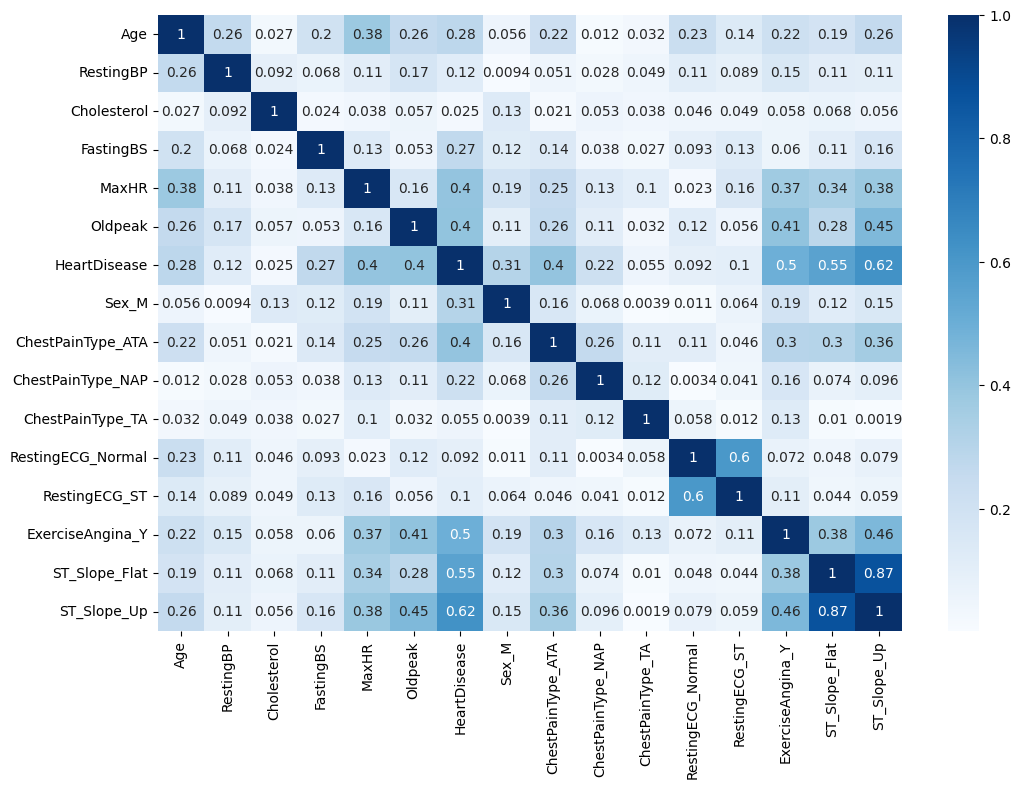

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

correlations = abs(hd_clean.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap="Blues")


<Axes: >

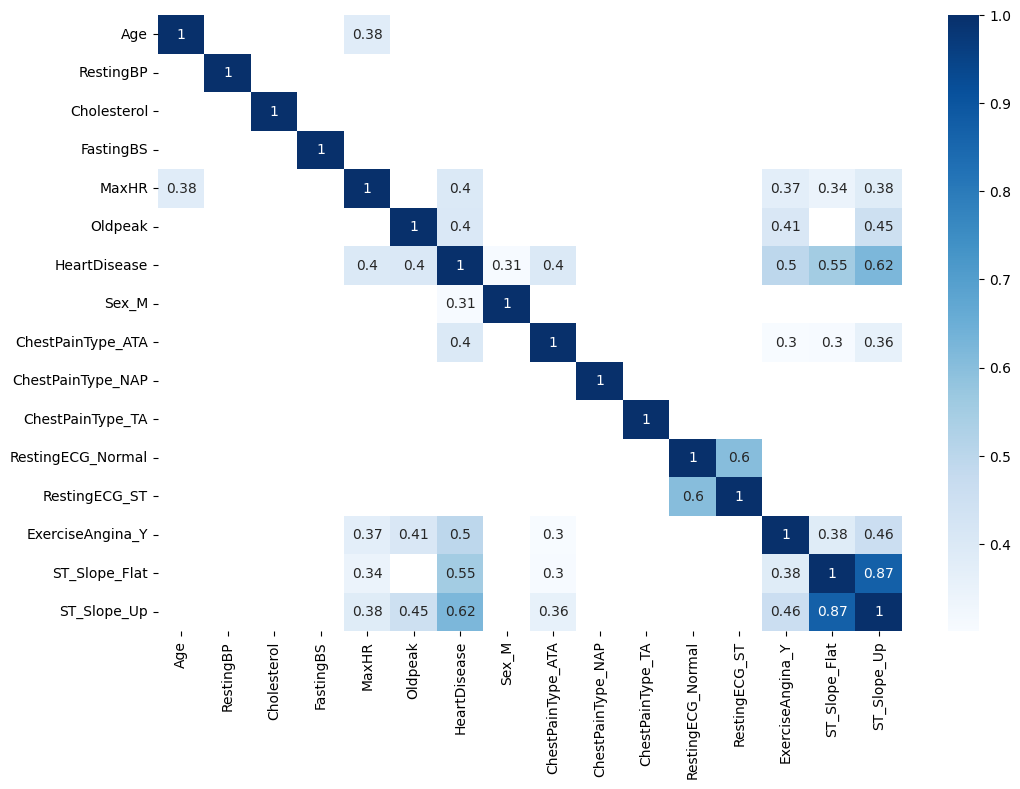

In [94]:
plt.figure(figsize=(12,8))
sns.heatmap(correlations[correlations > 0.3], annot=True, cmap="Blues")

From our correlation heatmap, we can identify the following features to be positively correlated (correlation coefficient greater than 0.3) to `HeartDisease`:

- `Oldpeak`
- `MaxHR`
- `ChestPainType_ATA` 
- `ExerciseAngina_Y`
- `ST_Slope_Flat`
- `ST_Slope_Up`

The correlation coefficient threshold was chosen arbitrarily. Surprisingly, `Cholesterol` is not strongly correlated to `HeartDisease`. We can consider ignoring the feature for now.

Given everything we have attempted so far, we can narrow down our features to the following:

- `Oldpeak`
- `Sex_M`
    - It has a relatively low value for the coefficient, but given what we observed in our EDA, let's also take it into account.
- `ExerciseAngina_Y`
- `ST_Slope_Flat`
- `ST_Slope_Up`

Time to create our model using these features!

## Building a Classifier with One Feature

We will split our dataset into a training and a test set first.

In [96]:
X = hd_clean.drop(["HeartDisease"], axis=1)
y = hd_clean["HeartDisease"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state = 417)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

We will start with creating a model for each of the features above and evaluate their performance using accuracy as a metric.

In [97]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 3 has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on Oldpeak and with k = 3 has an accuracy of 76.81%
The k-NN classifier trained on Sex_M and with k = 3 has an accuracy of 44.93%
The k-NN classifier trained on ExerciseAngina_Y and with k = 3 has an accuracy of 73.19%
The k-NN classifier trained on ST_Slope_Flat and with k = 3 has an accuracy of 81.88%
The k-NN classifier trained on ST_Slope_Up and with k = 3 has an accuracy of 84.06%


Our best forming model, with an accuracy of ~`82%`, was trained on the `ST_Slope_Flat` feature with `ExerciseAngina_Y` being a close second. These make sense given the data distributions we saw previously.

We will train a model using all of these features next.

## Building a Classifier with Multiple Features

Before training on all of the above features, we need to normalize the data first. We will use scikit-learn's MinMaxScaler to scale the values between 0 and 1, and then train the model again.

In [98]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

In [99]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 86.23


The model's accuracy jumped to ~`83%`! That's not a significant improvement, but still a good start. Using all these features results in an improved model, but, let's see what parameters/hyperparameters might be optimal.

## Hyperparameter Optimization

Let's prepare our data first.

In [101]:
X = hd_clean.drop(["HeartDisease"], axis=1)
y = hd_clean["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 417)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

We will use grid search to explore the following range of values for a couple of hyperparameters:

- For `k` (`n_neighbors` in scikit-learn) we will use values in the range of 1 to 20.
- We will use two distance metrics - `minkwoski` and `manhattan`.

`minkwoski` is the default metric for KNeighborsClassifier in sklearn, so we don't expect `manhattan` to do better. But, let's see what happens!

In [ ]:
grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"]
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 20)},
             scoring='accuracy')

In [ ]:
knn_grid.best_score_*100, knn_grid.best_params_

(83.43507030603806, {'metric': 'minkowski', 'n_neighbors': 19})

Our best model had an accuracy of ~`83%` with `19` `n_neighbors` and `minkowski` as the distance metric. 

The accuracy of this model is only slightly better. Since `GridSearchCV` employs a cross-validation approach, it is reasonable to assume that this is a better estimate of how the model performs compared to our prior attempt.

We will evaluate our model on our test set now.

## Model Evaluation on Test Set

We need to first normalize our test set similar to how we scaled our training set.

In [ ]:
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 86.96


Our model got an accuracy of ~`87`%. That's really good! This means that our model is likely to correctly predict whether a patient is at risk for a heart disease ~`87`% of the time.

However, the accuracy being higher than that of our training data's raises some flags.

One explanation that could explain is to look at how the data is distributed. 

In [ ]:
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the test dataset")
print(X_test.Sex_M.value_counts())

Distribution of patients by their sex in the entire dataset
1    724
0    193
Name: Sex_M, dtype: int64

Distribution of patients by their sex in the training dataset
1    615
0    164
Name: Sex_M, dtype: int64

Distribution of patients by their sex in the test dataset
1    109
0     29
Name: Sex_M, dtype: int64


We used `Sex` as one of our features for training the model.

- `X` had `724` males and `193` females.
- `X_train` had `615` males and `164` females.
- `X_test` had `109` males and `29` females.


We can see that the above datasets have a significantly higher number of male patients than female ones. We briefly mentioned previously that this could present a bias because of this imbalance in our dataset and we can see it potentially impacts our model. If the test dataset doesn't have that many female patients and the model was trained on a dataset with more male patients, then it is understandable it has better accuracy on the test set. Of course, there could be other factors contributing to this discrepancy.

## Summary and Next Steps

Our final model was trained using the following features:

- `Oldpeak`
- `Sex_M`
- `ExerciseAngina_Y`
- `ST_Slope_Flat`
- `ST_Slope_Up`

and had a test set accuracy of `86.96`%. However, given the limitations of our data this accuracy might not be indicative of a well performing model.

There are quite a few things we could try next to get better results:

- Try out different features.
- Expand the grid search parameters to identify more optimal hyperparameters.
- Explore other algorithms that might perform better than k-NN.
- Try and collect more data.